In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [3]:
#https://www.kaggle.com/datasets/sriharshaeedala/amazon-stock-price-from-1999-to-2022
#Read data frame into project
df = pd.read_csv('AMZN_data_1999_2022.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-04,2.730729,2.966667,2.665625,2.957813,2.957813,785844000
1,1999-01-05,2.739063,3.243750,2.662500,3.112500,3.112500,1257464000
2,1999-01-06,3.409375,3.509375,3.350000,3.450000,3.450000,723532000
3,1999-01-07,3.428125,4.006250,3.325000,3.971875,3.971875,945492000
4,1999-01-08,4.606250,4.978125,3.800000,4.006250,4.006250,1333244000
...,...,...,...,...,...,...,...
6034,2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
6035,2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000
6036,2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600
6037,2022-12-29,82.870003,84.550003,82.550003,84.180000,84.180000,54995900


In [16]:
#Make an even date range based off of input dataframe
start_date = df['Date'].min()
end_date = df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

#Make dataframe of all evenly spaced dates using an outer join to create entries for missing dates
df2 = pd.DataFrame(range(len(date_range)), index=date_range)
df2[0] = df2.index
df2.rename(columns={0: 'Date'}, inplace=True)
sortedDF = df2.merge(df, on='Date', how='outer')
sortedDF.drop(columns=['Open','High','Close','Adj Close','Volume'], inplace=True)
sortedDF

,Date,Low
0,1999-01-04,2.665625
1,1999-01-05,2.662500
2,1999-01-06,3.350000
3,1999-01-07,3.325000
4,1999-01-08,3.800000
...,...,...
8757,2022-12-26,NaN
8758,2022-12-27,83.000000
8759,2022-12-28,81.690002
8760,2022-12-29,82.550003


In [17]:
#Number of NA values
sortedDF.isna().sum()

Date       0
Low     2723
dtype: int64

In [18]:
#use interpolation to fill in NA values
sortedDF['Low'].interpolate(method='linear', limit_direction='both', inplace=True)
sortedDF.set_index('Date', inplace=True)


In [19]:
sortedDF

,Low
Date,
1999-01-04,2.665625
1999-01-05,2.662500
1999-01-06,3.350000
1999-01-07,3.325000
1999-01-08,3.800000
...,...
2022-12-26,82.982500
2022-12-27,83.000000
2022-12-28,81.690002


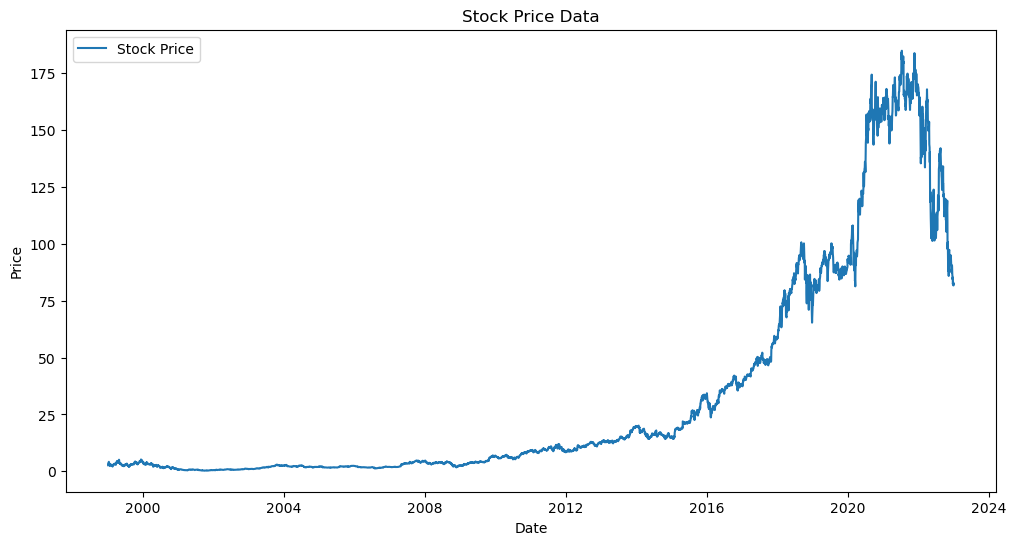

C:\Users\deges\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


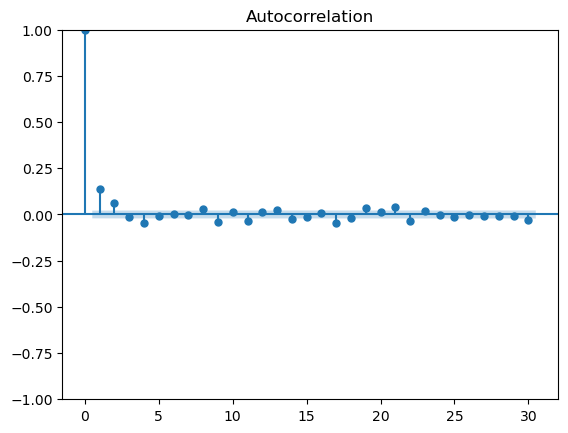

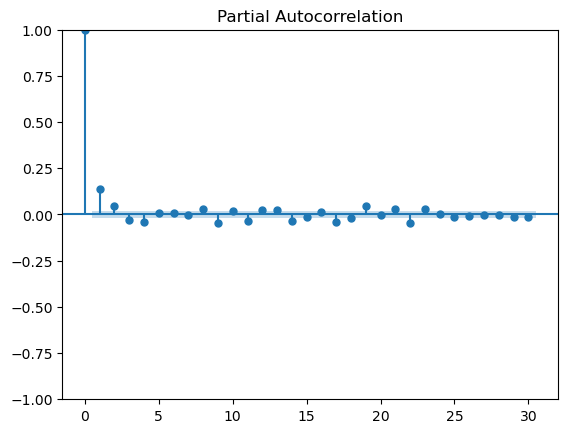

C:\Users\deges\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\deges\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\deges\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\deges\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\deges\AppData\Local\Temp\ipykernel_18024\3764202996.py:32: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = p

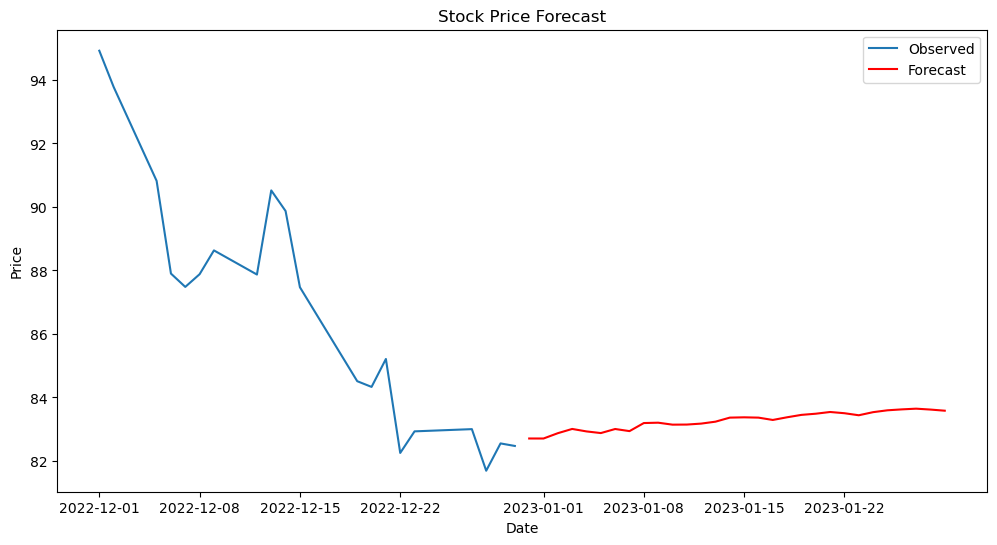

In [ ]:
# EDA and visualization
plt.figure(figsize=(12, 6))
plt.plot(sortedDF['Low'], label='Stock Price')
plt.title('Stock Price Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Differencing
sortedDF['Differenced'] = sortedDF['Low'].diff()

# ACF and PACF plots for order selection
sm.graphics.tsa.plot_acf(sortedDF['Differenced'].dropna(), lags=30)
sm.graphics.tsa.plot_pacf(sortedDF['Differenced'].dropna(), lags=30)
plt.show()

# Order selection (based on ACF and PACF plots)
model = ARIMA(sortedDF['Low'], order=(10, 1, 8))

# Model summary
model_fit = model.fit()

# Define the number of steps to forecast
forecast_steps = 30  # Set the correct number of forecast steps

# Make predictions for the next time steps
forecast = model_fit.forecast(steps=forecast_steps)

# Plotting the forecast using the updated code
plt.figure(figsize=(12, 6))
plt.plot(sortedDF.index[-30:], sortedDF['Low'][-30:], label='Observed')
plt.plot(forecast.index, forecast, color='red', label='Forecast')
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()